## Importing financial Data

### Resources

##### Data scaping library
- https://pandas-datareader.readthedocs.io/en/latest/

#### Fred Data Bank
- https://fred.stlouisfed.org/series/TY6MCD/

###### In this model we will recreate the CAPM model that we saw in finance class 

### Inputs
 - risk free rate
 - market return 
 - beta   (for each stock)
  - market variance 
  - stock variance 

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf # ticker data 
from pandas_datareader import data as pdr # market proxy and treasury rates data
import datetime as dt
from numpy import nan
from time import sleep
import concurrent.futures
from functools import reduce
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy 
import time

In [2]:
# save the tickers in objects

market_proxy = 'SP500'  # this is for FRED
spy500 = 'SPY'         # this is for Yahoo

ticker_list = ['GLD', 'CCJ', 'UCO', 'SQ', 'SES.TO', 'CNQ', 'IFOS.V']

In [3]:
startdate = '2014-01-01'
enddate = str(dt.date.today())

In [4]:
# Calculate the number of years (this will ensure robustness of the model)
# Convert the date string to a datetime object
date = datetime.strptime(startdate, "%Y-%m-%d")
# Get the current date
current_date = datetime.now()
# Calculate the difference between the current date and the input date
difference = current_date - date
# Calculate the number of years
years = round(difference.days / 365.25)
years

9

## Get the Risk-Free-Rate

#### This example reads 6-month constant maturity yields on U.S. treasury bills

In [5]:
rf_data = pdr.get_data_fred('TY6MCD', start=startdate, end=enddate)
rf_data.tail()

,TY6MCD
DATE,
2022-10-01,3.92
2022-11-01,4.57
2022-12-01,4.70
2023-01-01,4.76
2023-02-01,4.80


## Approximate the market returns

In [6]:
# using the S&P as a market proxy, we will import the historical data
spy = pdr.get_data_fred(market_proxy, start = startdate, end=enddate).dropna().reset_index().rename(columns={'DATE':'Date'})


# add a column for time as an index
time = np.arange(1, len(spy) + 1)
spy['time'] = time
spy.head()

,Date,SP500,time
0,2014-01-02,1831.98,1
1,2014-01-03,1831.37,2
2,2014-01-06,1826.77,3
3,2014-01-07,1837.88,4
4,2014-01-08,1837.49,5


#### next we will fit a trend line to the data and find the compounding annua  returns

In [7]:
#now the independant variable is time, and the dependant variable is the SPY
# the output will give you the slope of the line on left, and the y intercept on right
# as time (right value) increases by one, the (left value) price at close moves up by ____.

# note: the time frame must be the same if youre to get the trendline to overlap the price graph
# the polyfit() function will return 2 values. the first will  be the slope of the trend line,and the second is the y-intercept 
reg = np.polyfit(spy['time'], spy['SP500'], deg = 1)

#make an array to store the trend line values
# the second set of [] in data['time'][-22:] will indicate what tiume period to put the line on 

# the polyval() function will return an array of values. each value is the y coordinate for each day on the x axis 
trend = np.polyval(reg, spy['time'])
trend

array([1523.03991269, 1524.22216041, 1525.40440813, ..., 4238.66292231,
       4239.84517002, 4241.02741774])

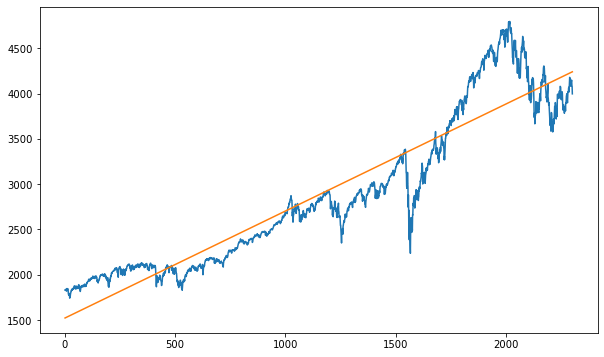

In [8]:
plt.figure(figsize=(10,6))

plt.plot(spy['time'], spy['SP500'], label = 'SPY')

plt.plot(spy['time'], trend)

### Calculate the Compound Returns


In [9]:
start_val = trend[0]   # get the first value in the array
end_val = trend[-1:]   # get the last value in the array

number_of_years = len(trend)/252   # divide the array by 252 (the number of trading days in one year)

compound_ann_returns = (end_val / start_val) ** (1 / number_of_years) - 1   # calculate compount retunrs 

expected_market_return = compound_ann_returns[0]
expected_market_return

0.11874267218929191

### Next we need to calculate Beta for each stock
- for this we will use 2 years of monthly data
- recall that we use 60 observastions when calculating beta

In [36]:
# first we need to make a merged dataframe including all the stocks and the market proxy


def get_merged_df(market_proxy, ticker_list, years=5):
    
    period = str(years) + 'y'  # make the variable for the period argument in df.history()
    
    proxy_data = yf.Ticker(market_proxy) # first we ge the data on hte market proxy (spy in this case)
    main_df = proxy_data.history(period=period)[['Close']].rename(columns={'Close':'market_proxy'}).reset_index()
    
    df_dict = {} # this will hold the dfs
    
    for ticker in ticker_list:  # collect the historical quotes in the df_dict
        ticker_data = yf.Ticker(ticker)
        ticker_hist = ticker_data.history(period=period)[['Close']].rename(columns={'Close':ticker}).reset_index()
        df_dict[ticker] = ticker_hist
    
    # merge the dataframes into one df
    for key in df_dict.keys():
        main_df = pd.merge(main_df, df_dict[key], how='left', on='Date')
    return main_df, df_dict

In [37]:
main_df, df_dict = get_merged_df(spy500, ticker_list, years = years)
main_df

,Date,market_proxy,GLD,CCJ,UCO,SQ,SES.TO,CNQ,IFOS.V
0,2014-02-24,156.675659,128.990005,18.673534,2181.875000,NaN,13.849586,25.339413,108.00
1,2014-02-25,156.616302,129.210007,20.198092,2156.250000,NaN,13.583096,25.209469,117.00
2,2014-02-26,156.624817,128.110001,21.149830,2174.375000,NaN,13.679577,25.052174,113.00
3,2014-02-27,157.446671,128.199997,21.149830,2168.750000,NaN,13.608985,24.819637,106.00
4,2014-02-28,157.844940,127.620003,21.378954,2179.375000,NaN,13.844293,25.045330,109.00
...,...,...,...,...,...,...,...,...,...
2260,2023-02-14,412.640015,172.610001,29.160000,29.400000,78.800003,8.390000,60.220001,1.61
2261,2023-02-15,413.980011,170.889999,29.620001,29.080000,82.690002,8.480000,59.430000,1.62
2262,2023-02-16,408.279999,170.750000,28.750000,28.610001,78.629997,8.290000,58.470001,1.62
2263,2023-02-17,407.260010,171.259995,28.790001,27.389999,75.019997,8.100000,55.700001,1.59


### Now we can calculat the variance between the market proxy and each stock 

In [38]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2265 entries, 0 to 2264
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2265 non-null   datetime64[ns]
 1   market_proxy  2265 non-null   float64       
 2   GLD           2265 non-null   float64       
 3   CCJ           2265 non-null   float64       
 4   UCO           2265 non-null   float64       
 5   SQ            1825 non-null   float64       
 6   SES.TO        2218 non-null   float64       
 7   CNQ           2265 non-null   float64       
 8   IFOS.V        1895 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 177.0 KB


In [39]:
for col in main_df.columns[1:]:
    col_name = col + '_pct'
    
    main_df[col_name] = main_df[col].pct_change(periods=21)

In [40]:
main_df.columns[9:]  # this just shows that the columns were looking for are from inxed 9 forward

Index(['market_proxy_pct', 'GLD_pct', 'CCJ_pct', 'UCO_pct', 'SQ_pct',
       'SES.TO_pct', 'CNQ_pct', 'IFOS.V_pct'],
      dtype='object')

In [41]:
# now we will make a list os 60 data points for each stock 

return_dict = {}

for col in main_df.columns[9:]:
    return_dict[col] = []
    temp_list = []
    i = len(main_df) - 1
    while i > 0:
        
        return_dict[col].append(main_df[col][i])
        i -= 21
    return_dict[col] = return_dict[col][:60]

return_dict['GLD_pct'] # example show of values

[-0.04835740138106126,
 0.07798211514403564,
 0.014641344449014992,
 0.08062492933417409,
 -0.021796638441795024,
 -0.047013236474282016,
 0.015286684238662529,
 -0.060716171329109114,
 -0.007445749241054789,
 -0.059110079661214954,
 0.01129135199865483,
 0.0192947710518776,
 0.03004415454400755,
 0.02550654768448779,
 -0.03839539798419589,
 0.05469932438009617,
 0.0030920001169341127,
 -0.010023396931922002,
 -0.01273995002646966,
 0.010841554906735773,
 -0.05120487282247266,
 0.04657111523021862,
 0.031472422593941785,
 -0.024010506189626857,
 -0.047779262854066085,
 -0.007638373099223661,
 0.0013598044938474274,
 -0.010594760895313415,
 -0.026255445626195528,
 0.005267731706220413,
 0.05341043637667098,
 0.054685126424784736,
 -0.003765533800002996,
 0.03808078471023357,
 0.13203911155099357,
 -0.08070338400507315,
 0.03863975709888767,
 0.05553158526432589,
 0.0028856526429341667,
 -0.013099896829906865,
 -0.005804020898320217,
 -0.006539679984978286,
 0.057716697223967106,
 0.0254

In [42]:
return_dict.keys()

dict_keys(['market_proxy_pct', 'GLD_pct', 'CCJ_pct', 'UCO_pct', 'SQ_pct', 'SES.TO_pct', 'CNQ_pct', 'IFOS.V_pct'])

In [44]:
# Note: covariance is not the same as correlation. you might be asking why the diagonals on the matrix are not 1

covariance_df = pd.DataFrame(return_dict).cov().reset_index().rename(columns={'index':'comp'})
covariance_df

,comp,market_proxy_pct,GLD_pct,CCJ_pct,UCO_pct,SQ_pct,SES.TO_pct,CNQ_pct,IFOS.V_pct
0,market_proxy_pct,0.003820,0.001282,0.004201,0.004636,0.009117,0.005974,0.007530,0.003856
1,GLD_pct,0.001282,0.001683,0.001983,-0.000158,0.002864,0.001131,0.002828,0.001264
2,CCJ_pct,0.004201,0.001983,0.024230,0.008660,0.013342,0.010807,0.015506,0.014076
3,UCO_pct,0.004636,-0.000158,0.008660,0.055925,0.011719,0.031473,0.021835,0.010019
4,SQ_pct,0.009117,0.002864,0.013342,0.011719,0.038723,0.012736,0.016104,0.009891
5,SES.TO_pct,0.005974,0.001131,0.010807,0.031473,0.012736,0.035343,0.022122,0.002320
6,CNQ_pct,0.007530,0.002828,0.015506,0.021835,0.016104,0.022122,0.028829,0.010936
7,IFOS.V_pct,0.003856,0.001264,0.014076,0.010019,0.009891,0.002320,0.010936,0.096556


# Not to forget the Beta formula 

- ## β=(cov(R_i,R_m )/(σ_m^2 )) 
note: we need to still stroe the individual data for each securuty in the dict

In [45]:
beta_dict = {}

for col in covariance_df.columns[2:]:
    beta_dict[col.split('_')[0]] = []
    
    cov = float(covariance_df[covariance_df[covariance_df.columns[0]] == col][covariance_df.columns[1]])
    
    market_var = np.var(return_dict[covariance_df.columns[1]])
    
    beta = cov/market_var
    
    beta_dict[col.split('_')[0]].append(beta)
    
beta_df = pd.DataFrame.from_dict(beta_dict).T.reset_index().rename(columns={'index':'ticker', 0:'Beta'})
beta_df

,ticker,Beta
0,GLD,0.341283
1,CCJ,1.118391
2,UCO,1.234218
3,SQ,2.427157
4,SES.TO,1.590271
5,CNQ,2.004534
6,IFOS.V,1.026381


##### Note: we need to make this model robust by allowing for Beta calculations for each new row of data

- For this we will use the Fama-Mcbeth method which uses the window method to calculate beta, but it applies more weight to
recent observations thanto older ones


### Now that we have Beta, we can calculat the CAPM retunrs

##### Objects we will need

- beta_df ------------------- this holds all our beta values for each stock
- expected_market_return ---- this is self explanitory
- rf_data ------------------- this contains the risk-free-rate for a given date
- main_df ------------------- this holds all the historical prices


##### Remember the formula
- CAPM = R_f + B(R_m - R_f) 



In [46]:
# this is a static example, so we can predefine our variables 

R_m = expected_market_return 

R_f = float(rf_data[rf_data.columns[0]][-1:])/100

beta_df['CAPM'] = np.nan # lets make a new column where the capm returns will go


for ticker in beta_df['ticker']:
    B = float(beta_df[beta_df['ticker'] == ticker]['Beta'])
    
    CAPM_returns = R_f + B*(R_m-R_f)
    
    beta_df['CAPM'].iloc[beta_df['ticker'] == ticker] = CAPM_returns
    
beta_df

C:\Users\glenn\anaconda4\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,ticker,Beta,CAPM
0,GLD,0.341283,0.072143
1,CCJ,1.118391,0.127118
2,UCO,1.234218,0.135312
3,SQ,2.427157,0.219704
4,SES.TO,1.590271,0.160500
5,CNQ,2.004534,0.189806
6,IFOS.V,1.026381,0.120609


### Now lets make a simple risk/return chart
- this chart will allow us to visualize the comparable risk and return for each stock
- for this we need to calculate the VaR for each position 

In [47]:
def step_4_get_VaR(full_price_df):
    
    def VaR_1day(col, full_price_df=full_price_df):

        price_data_list = full_price_df[col].pct_change().tolist()
        returns = full_price_df[[col]]

        price_data_list = [item for item in price_data_list if not(pd.isnull(item)) == True]
        num_days = len(price_data_list)
        mu = np.mean(np.array(price_data_list))
        std = np.std(np.array(price_data_list))
        valueAtRisk = norm.ppf(0.05, mu, std)
        abs_VaR = abs(round(valueAtRisk*100, 4))

        mu_list = []
        std_list = []
        n_sims = 10000

        for x in range(100):
            sim_returns = np.random.normal(mu, std, n_sims)
            mu_mc = np.mean(sim_returns)
            std_mc = np.std(sim_returns)
            mu_list.append(mu_mc)
            std_list.append(std_mc)

        MC_VaR = round(abs(norm.ppf(0.05, np.mean(mu_list), np.mean(std_list)*100)), 4) 

        if abs_VaR > 30:
            abs_VaR = np.nan
        return (col, abs_VaR, MC_VaR, num_days)

    VaR_list = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(VaR_1day, col): col for col in full_price_df.columns.tolist()}
        for future in concurrent.futures.as_completed(futures):
            try:
                VaR_list.append(future.result())
            except:
                pass

    VaR_dict = {}
    columns = ['ticker', 'VaR_1day_%', 'MC_VaR_1day', 'trading_days_considered']
    for i in np.arange(len(VaR_list)):
        VaR_dict[i] = [VaR_list[i][0], VaR_list[i][1], VaR_list[i][2], VaR_list[i][3]]

    full_VaR_df = pd.DataFrame.from_dict(VaR_dict, orient='index', columns=columns)
    
    return full_VaR_df

In [48]:
# note that we need to ensure that only the columns containing the actual prices are included
VaR_df = step_4_get_VaR(main_df.iloc[:, 2:9])
VaR_df

,ticker,VaR_1day_%,MC_VaR_1day,trading_days_considered
0,SES.TO,5.8739,5.9136,2264
1,GLD,1.4525,1.4679,2264
2,CNQ,4.4425,4.5125,2264
3,UCO,8.1112,8.0487,2264
4,SQ,6.0190,6.1854,1824
5,CCJ,4.5211,4.5732,2264
6,IFOS.V,14.4401,14.6016,2264


In [49]:
## now lets make a new column for the VaR

# make a new column for VaR
beta_df['VaR'] = np.nan

# loop through and place the VaR in the apropriate cell
for ticker in beta_df['ticker']:  
    VaR = float(VaR_df.loc[VaR_df['ticker'] == ticker]['MC_VaR_1day'])/100  
    beta_df['VaR'].loc[beta_df['ticker'] == ticker] = VaR
    

C:\Users\glenn\anaconda4\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [50]:
beta_df

,ticker,Beta,CAPM,VaR
0,GLD,0.341283,0.072143,0.014679
1,CCJ,1.118391,0.127118,0.045732
2,UCO,1.234218,0.135312,0.080487
3,SQ,2.427157,0.219704,0.061854
4,SES.TO,1.590271,0.160500,0.059136
5,CNQ,2.004534,0.189806,0.045125
6,IFOS.V,1.026381,0.120609,0.146016


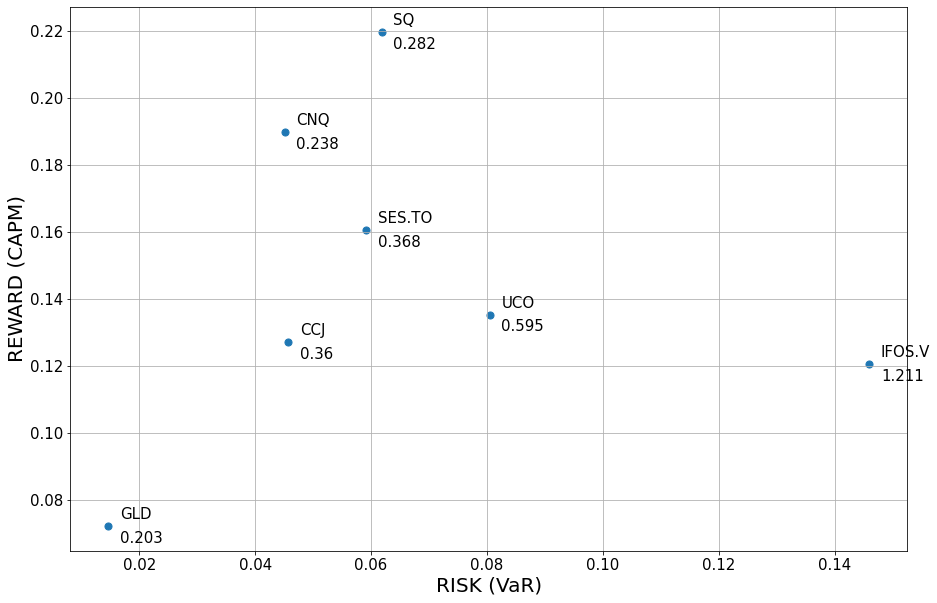

In [51]:
beta_df.plot.scatter(x = 'VaR', y='CAPM', figsize = (15,10), s = 50, fontsize = 15)
plt.xlabel('RISK (VaR)', size = 20)
plt.ylabel('REWARD (CAPM)', size = 20)
plt.grid(which='major')
for i in beta_df.set_index(keys='ticker').index:
    risk_ratio = round(beta_df.set_index(keys='ticker').loc[i, 'VaR']/beta_df.set_index(keys='ticker').loc[i, 'CAPM'], 3)
    plt.annotate(risk_ratio, xy=(beta_df.set_index(keys='ticker').loc[i, 'VaR']+0.002, beta_df.set_index(keys='ticker').loc[i, 'CAPM']-0.005), size=15)
    plt.annotate(i, xy=(beta_df.set_index(keys='ticker').loc[i, 'VaR']+0.002, beta_df.set_index(keys='ticker').loc[i, 'CAPM']+0.002), size=15)
    
    